# ***Set Parameters to define model etc***

In [ ]:
#### Undersampling Strategy:#####
Undersampling = "Regular" # Options: Regular or Possoin
Sampling_Mask = "Complementary_Masks" #Options: Single_Combination or One_Mask Complementary_Masks
AF = 3 #  acceleration factor

#### Model Input and Output ####
GT_Data = "LowRank" # Options: FullRank LowRank for GROUNDTRUTH!
Low_Rank_Input = True ## apply low rank to the input as well if True
trancuate_t = 30 # set this parameter to control at which time step you stop using the signal

####M Model Parameters ####
batch_size=64
num_convs = 6

In [2]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

#### Model import correct model
from Naive_CNN_3D_masked import * #from Naive_CNN_3D_Residual_No_Batch_Norm import *

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

In [3]:
#### Define ground truth path####
if GT_Data == "FullRank":
    ground_truth_path = "../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy"
elif GT_Data == "LowRank":
    ground_truth_path = "../data/Ground_Truth/Low_Rank/LR_8_P03-P08_self.npy"

#### Define Input Data path
undersampled_data_path = "../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy'

#### Definie Model path
if GT_Data == "FullRank":
    saved_model_path = f"../saved_models/Masked_Naive_CNN_3D/Full2Full/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/{num_convs}Layer/best_model.pth'
elif GT_Data == "LowRank":
    saved_model_path = f"../saved_models/Masked_Naive_CNN_3D/Low2Low/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/{num_convs}Layer/best_model.pth'
    
    
#### load data!
Ground_Truth = np.load(ground_truth_path)
Undersampled_Data = np.load(undersampled_data_path)
MASKS = np.load("../data/masks.npy")

####
mask_expanded = MASKS[:, :, :, None, None, :]  # Now shape is (22,22,21,1,1,6)
# Use broadcasting to "repeat" the mask along these new axes:
mask_extended = np.broadcast_to(mask_expanded, (22, 22, 21, 96, 8, 6))
mask_extended = mask_extended + 1J*mask_extended

#### additionally make LowRank 8 transformation on input of network, this improves the error significantly!
if Low_Rank_Input:
    Undersampled_Data[...,0] = low_rank(Undersampled_Data[...,0], 8)
    Undersampled_Data[...,1] = low_rank(Undersampled_Data[...,1], 8)
    Undersampled_Data[...,2] = low_rank(Undersampled_Data[...,2], 8)
    Undersampled_Data[...,3] = low_rank(Undersampled_Data[...,3], 8)
    Undersampled_Data[...,4] = low_rank(Undersampled_Data[...,4], 8)
    Undersampled_Data[...,5] = low_rank(Undersampled_Data[...,5], 8)

In [4]:
#### Train_Test_Split ####
ground_truth_train, ground_truth_test = Ground_Truth[:,:,:,:trancuate_t,:,1:6], Ground_Truth[:,:,:,:trancuate_t,:,0]  
Train_Mask, Test_Mask = mask_extended[:,:,:,:trancuate_t,:,1:6], mask_extended[:,:,:,:trancuate_t,:,0]

#### Assign undersampled network input ####
NN_input_train, NN_input_test = Undersampled_Data[:,:,:,:trancuate_t,:,1:6], Undersampled_Data[:,:,:,:trancuate_t,:,0]

#### Fourier transform ####
training_undersampled, test_undersampled = fourier_transform(NN_input_train), fourier_transform(NN_input_test)

#### Collapse ununsed dimensions ####
ground_truth_train, ground_truth_test = ground_truth_train.reshape(22, 22, 21, -1), ground_truth_test.reshape(22, 22, 21, -1)
NN_input_train, NN_input_test = NN_input_train.reshape(22, 22, 21, -1), NN_input_test.reshape(22, 22, 21, -1)
training_undersampled, test_undersampled = training_undersampled.reshape(22, 22, 21, -1), test_undersampled.reshape(22, 22, 21, -1)
Mask_train, Mask_test = Train_Mask.reshape(22, 22, 21, -1), Test_Mask.reshape(22, 22, 21, -1)

#### Normalize data #####
normalized_input_train, normalized_ground_truth_train, norm_values_train = normalize_data_per_image_new(NN_input_train, ground_truth_train)
normalized_input_test, normalized_ground_truth_test, norm_values_test = normalize_data_per_image_new(NN_input_test, ground_truth_test)
_, normalized_train_FT, _ = normalize_data_per_image_new(NN_input_train, training_undersampled)
_, normalized_test_FT, _ = normalize_data_per_image_new(NN_input_test, test_undersampled)

#### reshape for pytorch ####
train_data, train_labels  = reshape_for_pytorch(normalized_input_train, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_train, grouped_time_steps)
test_data, test_labels = reshape_for_pytorch(normalized_input_test, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_test, grouped_time_steps)
train_mask, test_mask = reshape_for_pytorch(Mask_train, grouped_time_steps), reshape_for_pytorch(Mask_test, grouped_time_steps)

# Prepare k-space data (reshape undersampled k-space as well)
train_k_space = reshape_for_pytorch(normalized_train_FT, grouped_time_steps)
test_k_space = reshape_for_pytorch(normalized_test_FT, grouped_time_steps)

In [5]:
#### Set parameters ####

augment = RandomAugment3D(rotation_range=0.3, shift_pixels=1,
                          apply_phase=True, apply_rotation=True, apply_shift=True)

# Create TensorDataset instances
train_dataset = TensorDatasetWithAugmentation(train_data, train_labels, train_mask, transform=augment)
test_dataset = TensorDatasetWithAugmentation(test_data, test_labels, test_mask, transform=None)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Number of convolutional layers
model = Naive_CNN_3D(grouped_time_steps=grouped_time_steps, num_convs=num_convs).to(device)

#saved_model_path = "../saved_models/Naive_CNN_3D_AF_3_Non_Residual/5Layer/model.pth"  # Replace with your file path

# 2. Load the model's state_dict (weights) from the saved file

checkpoint = torch.load(saved_model_path, map_location=device)
# Extract the model state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [6]:
def Process_Model_Output(test_loader, model, device, trancuate_t, T, grouped_time_steps, abs_test_set = []): ## this is for a network that processes k-space and image space simulattenously (deeper)
    """
    Compute model predictions and bring them back to the original unpreprocessed format for statistics.
    Also output the ground truth in the same format.

    Parameters:
        test_loader (DataLoader): DataLoader for the test set.
        model (torch.nn.Module): The trained PyTorch model.
        device (torch.device): Device to perform computations on (e.g., 'cuda' or 'cpu').
        inverse_preprocess (function): Function to revert preprocessing on the data.
        t, T, grouped_time_steps: Parameters for inverse_preprocess function.
        abs_test_set: needed to denormalize the original normalization of data, for comparison to other models NORMALIZATION VALUES

    Returns:
        tuple: The original shape of outputs and labels after inverse preprocessing.
    """
    # Set the model to evaluation mode
    model.eval()

    # Initialize lists to store outputs and labels
    outputs_list = []
    inputs_img_list = []
    input_kspace_list = []
    labels_list = []

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for data, labels, masks in test_loader:
            # Unpack the tuple returned by the dataset
            inputs_img = data

            # Move the tensors to the appropriate device
            inputs_img = inputs_img.to(device)
            labels = labels.to(device)

            # Pass the inputs as a tuple to the model
            outputs = model((inputs_img))

            # If outputs is a tuple, extract the first element
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            # Append outputs and labels to the lists
            outputs_list.append(outputs.cpu().numpy())  # Convert to numpy and move to CPU
            labels_list.append(labels.cpu().numpy())   # Convert to numpy and move to CPU
            inputs_img_list.append(inputs_img.cpu().numpy())


#     # Convert to final arrays
    outputs_array = np.concatenate(outputs_list, axis=0)
    inputs_img = np.concatenate(inputs_img_list, axis=0)
    labels_array = np.concatenate(labels_list, axis=0)

    outputs_array = inverse_reshape_for_pytorch(outputs_array, grouped_time_steps)
    inputs_img = inverse_reshape_for_pytorch(inputs_img, grouped_time_steps)
    labels_array = inverse_reshape_for_pytorch(labels_array, grouped_time_steps)
    
    
    denormalized_input = denormalize_data_per_image(inputs_img, abs_test_set.reshape(-1))
    denormalized_output = denormalize_data_per_image(outputs_array, abs_test_set.reshape(-1))
    denormalized_labels = denormalize_data_per_image(labels_array, abs_test_set.reshape(-1))

    denormalized_input = reshape_for_pytorch(inputs_img, grouped_time_steps)
    denormalized_output = reshape_for_pytorch(denormalized_output, grouped_time_steps)
    denormalized_labels = reshape_for_pytorch(denormalized_labels, grouped_time_steps)

    denormalized_output = inverse_preprocess(denormalized_output, trancuate_t, T, grouped_time_steps)
    denormalized_labels = inverse_preprocess(denormalized_labels, trancuate_t, T, grouped_time_steps)

    return denormalized_output, denormalized_labels

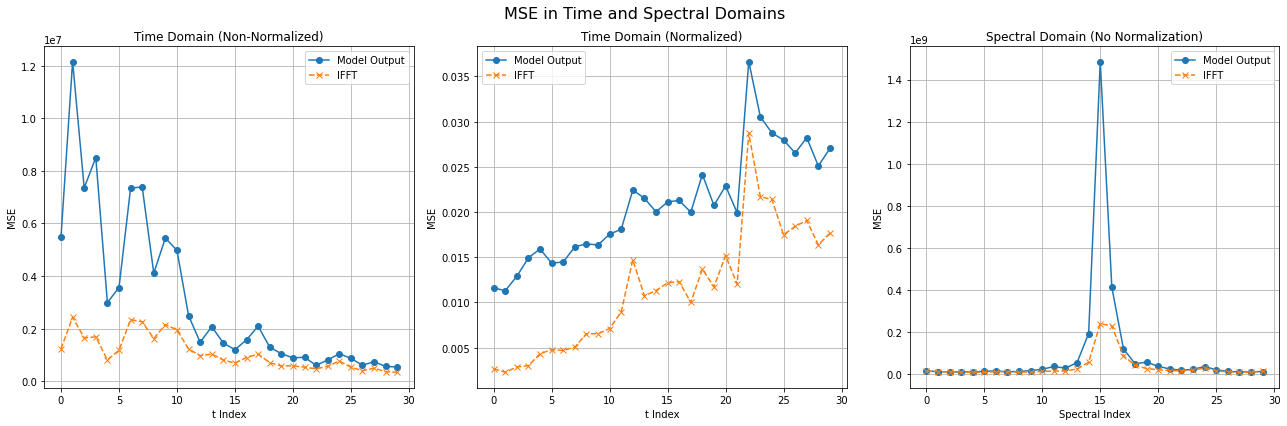

==== Model Output vs Ground Truth ====
Total MSE in image domain: 1526900.2805294269
Normalized Total MSE in image domain: 0.01041431226726079
Total MSE in spectral domain: 45807008.41588282

==== Model Input vs Ground Truth ====
Total MSE in image domain: 538324.1427319822
Normalized Total MSE in image domain: 0.005720415435433284
Total MSE in spectral domain: 16149724.281959467


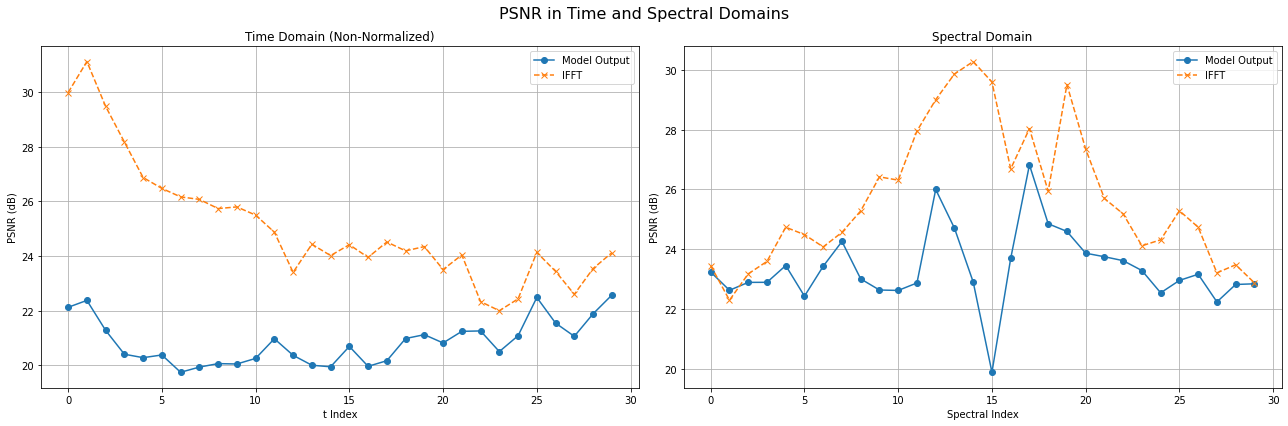

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    20.848569908478446
Average PSNR in frequency domain: 23.36705253771141

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    25.0492924094374
Average PSNR in frequency domain: 25.718716142422885


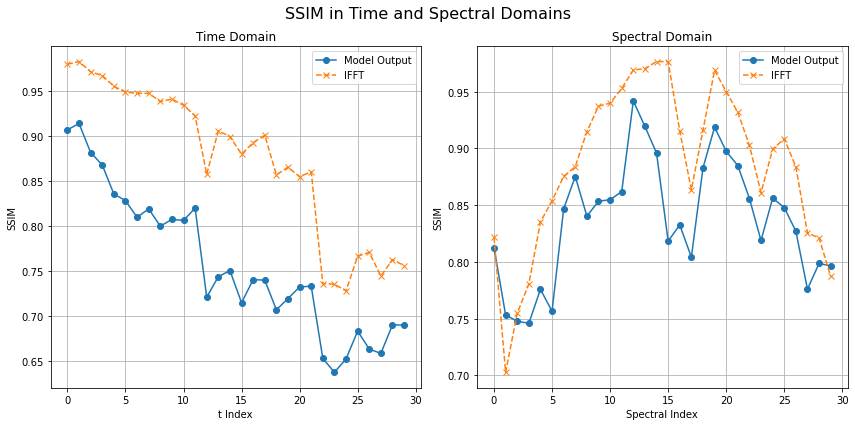

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.7572825669333236
Average SSIM in frequency domain: 0.8365613547794152

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.8733086435736415
Average SSIM in frequency domain: 0.8860061720911686


In [7]:
Model_Outputs_Test_Set, ground_truth = Process_Model_Output(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)


ground_truth = Ground_Truth[:,:,:,:trancuate_t,:,0]

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,0]

mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]



Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D
ground_truth = ground_truth*mask_5D
norm_values_test = norm_values_test.reshape(trancuate_t,8)
### to be fair, I compute a LR approximation, as a trivial baseline comparison + apply the mask
model_input = low_rank(Undersampled_Data[...,0], 8)*mask_5D
model_input = model_input[:,:,:,:trancuate_t,:]

plot_general_statistics(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)
plot_general_statistics_PSNR(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test)
plot_general_statistics_SSIM(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test,  label = "Model Output")

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


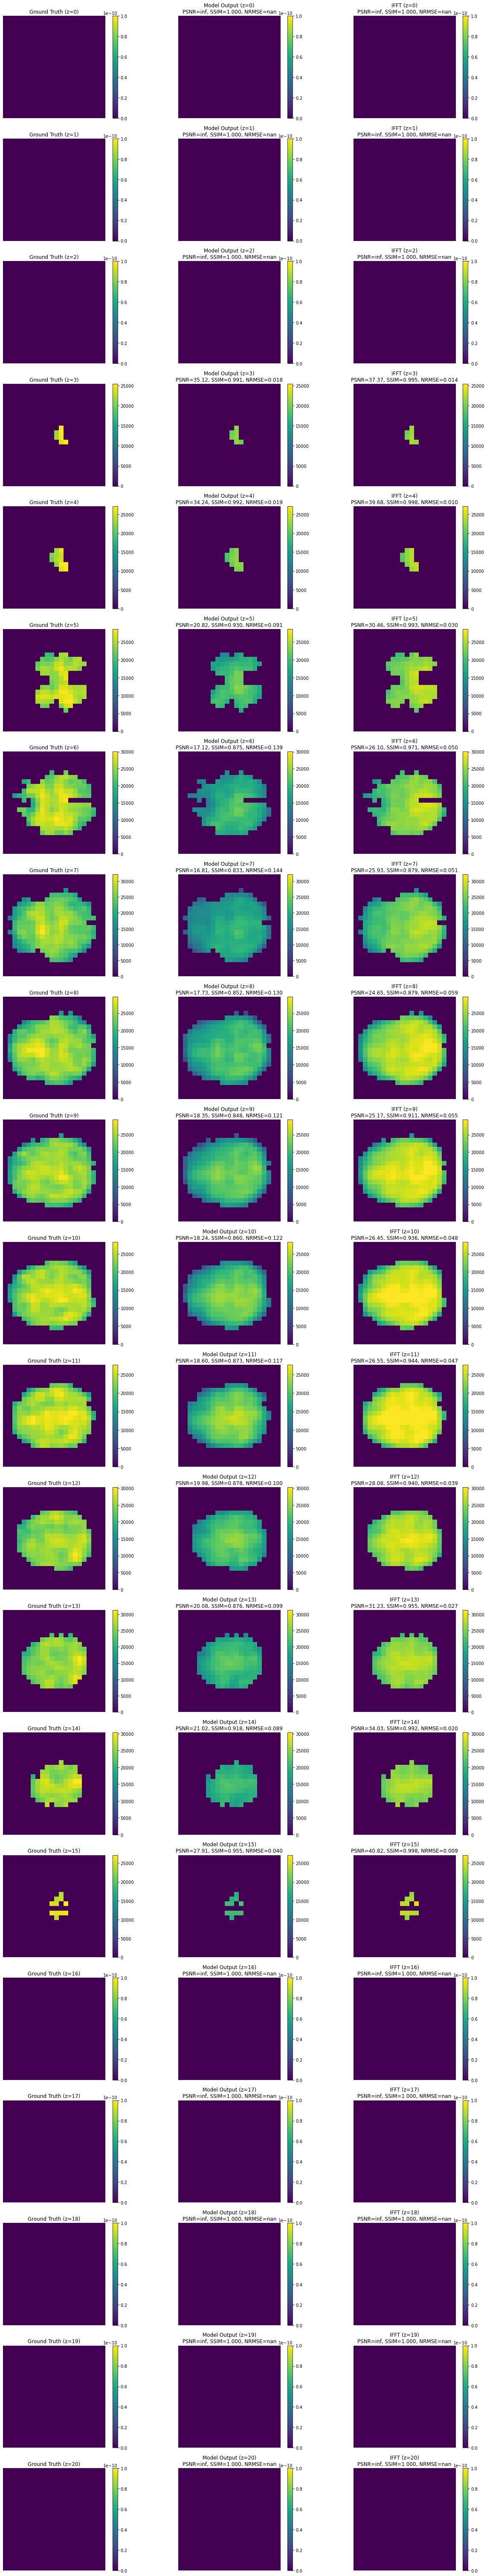

In [8]:
tf = 1 #15 = Water, 17 Glucose, 23 Glx
T = 0

ground_truth = ground_truth*mask_5D
comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, tf, T, domain="time")

In [9]:
Model_Outputs_Test_Set, ground_truth = Process_Model_Output(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,0]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D

norm_values_test = norm_values_test.reshape(trancuate_t,8)
model_input = Undersampled_Data[:,:,:,:trancuate_t,:,0]
ground_truth = ground_truth*mask_5D
### to be fair, I compute a LR approximation, as a trivial baseline comparison + apply the mask
model_input = low_rank(model_input, 8)*mask_5D

ground_truth_spectral = np.fft.fftshift(np.fft.fft(ground_truth, axis=-2), axes=-2)
model_pred_spectral = np.fft.fftshift(np.fft.fft(Model_Outputs_Test_Set, axis=-2), axes=-2)
IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)


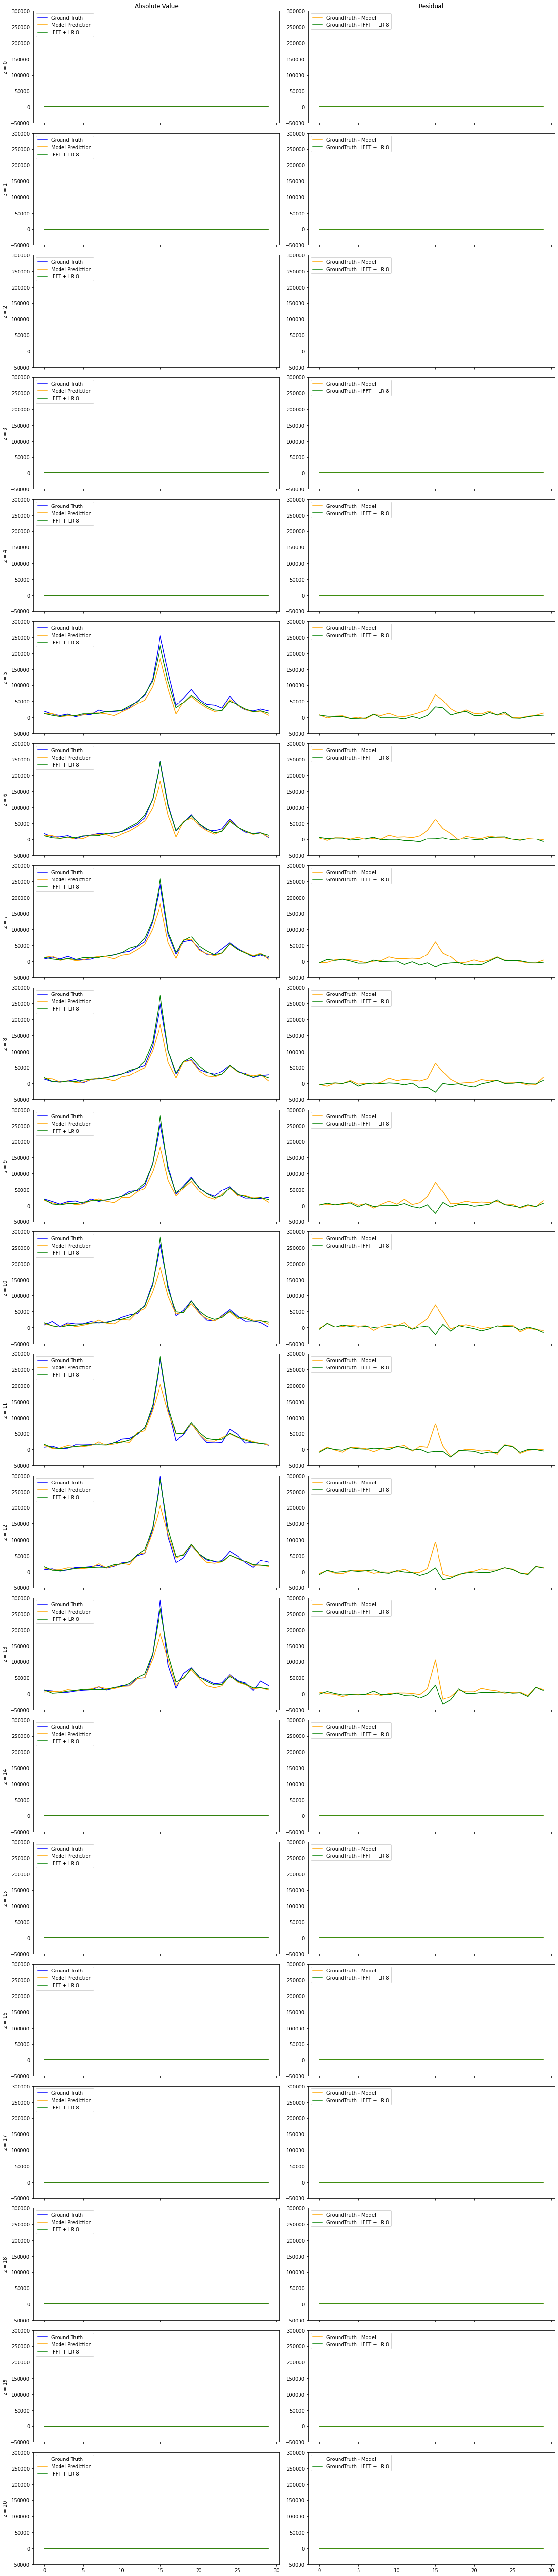

In [10]:
model_input = Undersampled_Data[:,:,:,:trancuate_t,:,0]
model_input = low_rank(model_input, 8)*mask_5D

IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)
# Fixed indices for x, y, and T:
# ----------------------------------------------------------------------
# Fixed indices for x, y, and T
# ----------------------------------------------------------------------
x_fixed = 15
y_fixed = 15
T_fixed = 7

num_z = 21  # Number of z slices

# ----------------------------------------------------------------------
# Create a figure with 2 columns:
#   Column 1 -> Absolute value plots
#   Column 2 -> Residuals (GT - [Others])
# ----------------------------------------------------------------------
fig, axes = plt.subplots(nrows=num_z, ncols=2, figsize=(16, num_z * 3.5), sharex=True)

# If there's only one row, ensure axes is 2D
if num_z == 1:
    axes = np.array([axes])

for z in range(num_z):
    # Extract the spectra at [x_fixed, y_fixed, z, :, T_fixed]
    gt_spec  = ground_truth_spectral[x_fixed, y_fixed, z, :, T_fixed]
    mp_spec  = model_pred_spectral[x_fixed, y_fixed, z, :, T_fixed]
    iff_spec = IFF_LR_8[x_fixed, y_fixed, z, :, T_fixed]
    
    # ------------------------------------------------------------------
    # Column 1: Plot absolute spectra
    # ------------------------------------------------------------------
    ax_abs = axes[z, 0]
    ax_abs.plot(np.abs(gt_spec),  label='Ground Truth',    color='blue')
    ax_abs.plot(np.abs(mp_spec),  label='Model Prediction',color='orange')
    ax_abs.plot(np.abs(iff_spec), label='IFFT + LR 8',     color='green')
    ax_abs.set_ylim(-50000, 300000)
    # Row label on the Y-axis
    ax_abs.set_ylabel(f'z = {z}')
    
    if z == 0:
        ax_abs.set_title('Absolute Value')
    ax_abs.legend(loc='upper left')
    
    # ------------------------------------------------------------------
    # Column 2: Plot residuals (Ground Truth - [Others])
    # ------------------------------------------------------------------
    ax_res = axes[z, 1]
    
    residual_gt_mp  = np.abs(gt_spec) - np.abs(mp_spec)
    residual_gt_iff = np.abs(gt_spec) - np.abs(iff_spec)
    
    ax_res.plot(residual_gt_mp,  label='GroundTruth - Model',        color='orange')
    ax_res.plot(residual_gt_iff, label='GroundTruth - IFFT + LR 8',  color='green')

    if z == 0:
        ax_res.set_title('Residual')
    ax_res.legend(loc='upper left')
    ax_res.set_ylim(-50000, 300000)
plt.tight_layout()
plt.show()


In [11]:
def visualize_augmentation(data, label, mask, slice_idx=None, channel=0):
    """
    Visualizes a slice from augmented 3D volumes.
    
    Args:
        data: Tensor of shape (C, H, W, D) representing the augmented data.
        label: Tensor of shape (C, H, W, D) representing the augmented label.
        mask: Tensor of shape (C, H, W, D) representing the augmented mask.
        slice_idx: Index of the slice in the D dimension to visualize. If None, use the center slice.
        channel: Which channel to visualize (e.g. 0 for the real part of the first complex pair).
    """
    # Ensure the tensors are on the CPU and convert to numpy arrays.
    data_np = data.detach().cpu().numpy()
    label_np = label.detach().cpu().numpy()
    mask_np = mask.detach().cpu().numpy()

    # Determine which slice to display.
    if slice_idx is None:
        D = data_np.shape[-1]
        slice_idx = D // 2

    # Extract the slice for the given channel.
    data_slice = data_np[channel, :, :, slice_idx]
    label_slice = label_np[channel, :, :, slice_idx]
    mask_slice = mask_np[channel, :, :, slice_idx]

    # Plot the slices.
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(data_slice, cmap='gray')
    axs[0].set_title('Augmented Data (Channel {})'.format(channel))
    axs[1].imshow(label_slice, cmap='gray')
    axs[1].set_title('Augmented Label (Channel {})'.format(channel))
    axs[2].imshow(mask_slice, cmap='gray')
    axs[2].set_title('Augmented Mask (Channel {})'.format(channel))
    plt.show()

# Example usage:
# Assume train_dataset is your augmented dataset.
sample_data, sample_label, sample_mask = train_dataset[0]
visualize_augmentation(sample_data, sample_label, sample_mask)